In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='5'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='mean_temp'
SAMPLE_SIZE=10000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v1', 'profile_list_v1_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_5_20250327_0427


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v1_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 261967/261967 [00:53<00:00, 4871.69it/s]

Saved 261967 profiles to /workspace/outputs/profiles_v1_experiment_5_20250327_0427/20250327-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 261967it [00:10, 25916.77it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250327_0427/density_plot.png


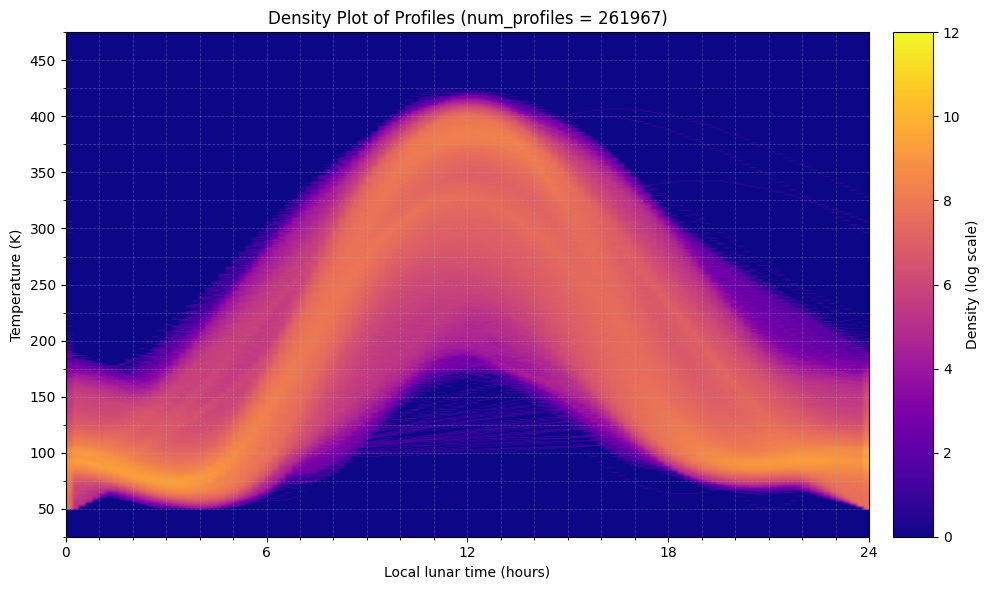

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250327_0427/histogram_max_temp.png


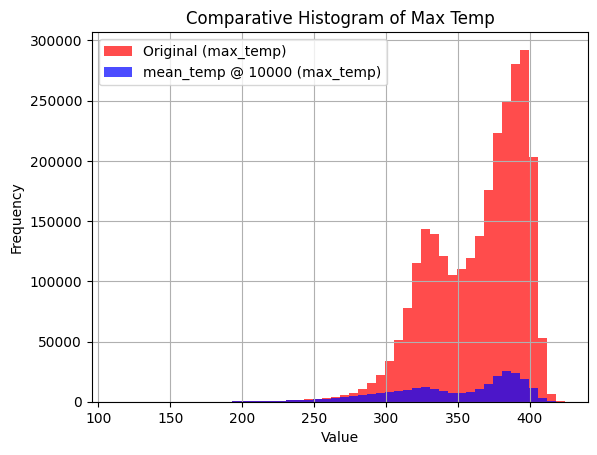

Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250327_0427/histogram_min_temp.png


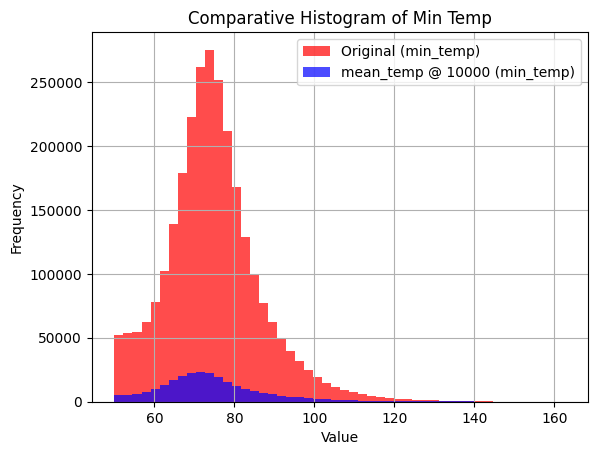

Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250327_0427/histogram_mean_temp.png


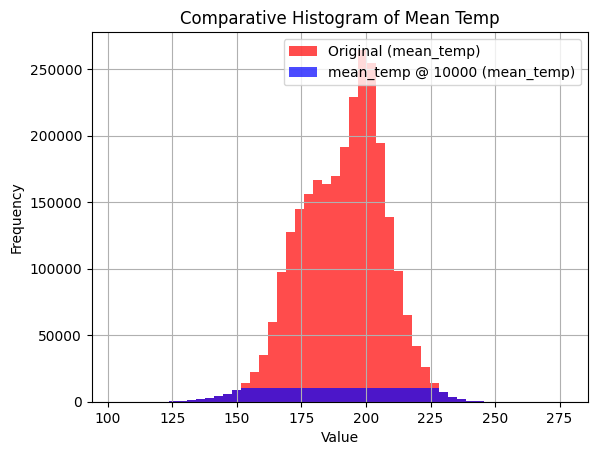

Saved figure to /workspace/outputs/profiles_v1_experiment_5_20250327_0427/histogram_std_temp.png


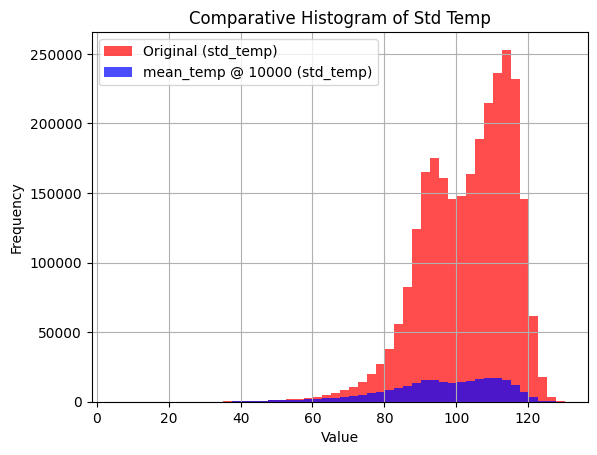

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 187.4136
STD: 101.1601
Min Temp: 50.0000
Max Temp: 424.6720
Datasets:
Training Data: 183376
Validation Data: 52393
Test Data: 26198


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 917/917 [00:28<00:00, 32.08it/s, best_loss=0.8139]


[Training] Epoch 1/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0012, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 262/262 [00:02<00:00, 105.49it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0001
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_5_20250327_0427'


[Training] Epoch 2/100: 100%|██████████| 917/917 [00:28<00:00, 31.90it/s, best_loss=0.8333]


[Training] Epoch 2/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 262/262 [00:02<00:00, 113.13it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 3/100: 100%|██████████| 917/917 [00:28<00:00, 32.02it/s, best_loss=0.8027]


[Training] Epoch 3/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 262/262 [00:02<00:00, 113.16it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 4/100: 100%|██████████| 917/917 [00:28<00:00, 31.98it/s, best_loss=0.8117]


[Training] Epoch 4/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 262/262 [00:02<00:00, 104.98it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 5/100: 100%|██████████| 917/917 [00:28<00:00, 32.24it/s, best_loss=0.8362]


[Training] Epoch 5/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 262/262 [00:02<00:00, 102.51it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 6/100: 100%|██████████| 917/917 [00:28<00:00, 31.99it/s, best_loss=0.8029]


[Training] Epoch 6/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 262/262 [00:02<00:00, 111.64it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 7/100: 100%|██████████| 917/917 [00:28<00:00, 32.21it/s, best_loss=0.8073]


[Training] Epoch 7/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 262/262 [00:02<00:00, 114.77it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 8/100: 100%|██████████| 917/917 [00:28<00:00, 31.90it/s, best_loss=0.8198]


[Training] Epoch 8/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 262/262 [00:02<00:00, 114.73it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 9/100: 100%|██████████| 917/917 [00:28<00:00, 31.87it/s, best_loss=0.8374]


[Training] Epoch 9/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 262/262 [00:02<00:00, 112.80it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 10/100: 100%|██████████| 917/917 [00:29<00:00, 31.49it/s, best_loss=0.7992]


[Training] Epoch 10/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 262/262 [00:02<00:00, 110.85it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 11/100: 100%|██████████| 917/917 [00:28<00:00, 31.80it/s, best_loss=0.8283]


[Training] Epoch 11/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 262/262 [00:02<00:00, 117.60it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 12/100: 100%|██████████| 917/917 [00:28<00:00, 31.94it/s, best_loss=0.8288]


[Training] Epoch 12/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 262/262 [00:02<00:00, 114.69it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 13/100: 100%|██████████| 917/917 [00:28<00:00, 31.76it/s, best_loss=0.8393]


[Training] Epoch 13/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 262/262 [00:02<00:00, 113.03it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 14/100: 100%|██████████| 917/917 [00:28<00:00, 32.30it/s, best_loss=0.8415]


[Training] Epoch 14/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 262/262 [00:02<00:00, 102.91it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 15/100: 100%|██████████| 917/917 [00:28<00:00, 32.39it/s, best_loss=0.7984]


[Training] Epoch 15/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 262/262 [00:02<00:00, 106.60it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 16/100: 100%|██████████| 917/917 [00:28<00:00, 32.53it/s, best_loss=0.7868]


[Training] Epoch 16/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 262/262 [00:02<00:00, 114.41it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 17/100: 100%|██████████| 917/917 [00:28<00:00, 32.21it/s, best_loss=0.8001]


[Training] Epoch 17/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 262/262 [00:02<00:00, 121.13it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 18/100: 100%|██████████| 917/917 [00:28<00:00, 32.18it/s, best_loss=0.8231]


[Training] Epoch 18/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 262/262 [00:02<00:00, 121.61it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 19/100: 100%|██████████| 917/917 [00:28<00:00, 32.71it/s, best_loss=0.7776]


[Training] Epoch 19/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 262/262 [00:02<00:00, 115.02it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 20/100: 100%|██████████| 917/917 [00:28<00:00, 32.68it/s, best_loss=0.7963]


[Training] Epoch 20/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 262/262 [00:02<00:00, 114.81it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 21/100: 100%|██████████| 917/917 [00:28<00:00, 32.20it/s, best_loss=0.8402]


[Training] Epoch 21/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 262/262 [00:02<00:00, 120.63it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 22/100: 100%|██████████| 917/917 [00:27<00:00, 32.90it/s, best_loss=0.8203]


[Training] Epoch 22/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 262/262 [00:02<00:00, 110.63it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 23/100: 100%|██████████| 917/917 [00:28<00:00, 32.73it/s, best_loss=0.8158]


[Training] Epoch 23/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 262/262 [00:02<00:00, 114.36it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 24/100: 100%|██████████| 917/917 [00:28<00:00, 32.07it/s, best_loss=0.8422]


[Training] Epoch 24/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 262/262 [00:02<00:00, 112.41it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 25/100: 100%|██████████| 917/917 [00:27<00:00, 32.98it/s, best_loss=0.8027]


[Training] Epoch 25/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 262/262 [00:02<00:00, 102.34it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 26/100: 100%|██████████| 917/917 [00:28<00:00, 32.65it/s, best_loss=0.7994]


[Training] Epoch 26/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 262/262 [00:02<00:00, 101.32it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 27/100: 100%|██████████| 917/917 [00:27<00:00, 32.97it/s, best_loss=0.8352]


[Training] Epoch 27/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 262/262 [00:02<00:00, 114.22it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 28/100: 100%|██████████| 917/917 [00:28<00:00, 32.04it/s, best_loss=0.8286]


[Training] Epoch 28/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 262/262 [00:02<00:00, 110.86it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 29/100: 100%|██████████| 917/917 [00:28<00:00, 32.35it/s, best_loss=0.8147]


[Training] Epoch 29/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 262/262 [00:02<00:00, 121.08it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 30/100: 100%|██████████| 917/917 [00:28<00:00, 32.63it/s, best_loss=0.8215]


[Training] Epoch 30/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 262/262 [00:02<00:00, 117.59it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 31/100: 100%|██████████| 917/917 [00:28<00:00, 32.73it/s, best_loss=0.8127]


[Training] Epoch 31/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 262/262 [00:02<00:00, 114.14it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 32/100: 100%|██████████| 917/917 [00:28<00:00, 32.15it/s, best_loss=0.8131]


[Training] Epoch 32/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 262/262 [00:02<00:00, 113.20it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 33/100: 100%|██████████| 917/917 [00:27<00:00, 32.94it/s, best_loss=0.8186]


[Training] Epoch 33/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 262/262 [00:02<00:00, 118.37it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 34/100: 100%|██████████| 917/917 [00:28<00:00, 32.49it/s, best_loss=0.8046]


[Training] Epoch 34/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 262/262 [00:02<00:00, 112.09it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 35/100: 100%|██████████| 917/917 [00:28<00:00, 32.42it/s, best_loss=0.8213]


[Training] Epoch 35/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 262/262 [00:02<00:00, 100.46it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 36/100: 100%|██████████| 917/917 [00:27<00:00, 32.76it/s, best_loss=0.8364]


[Training] Epoch 36/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 262/262 [00:02<00:00, 98.48it/s] 


[Validation] Epoch 36/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 37/100: 100%|██████████| 917/917 [00:28<00:00, 32.56it/s, best_loss=0.8112]


[Training] Epoch 37/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 262/262 [00:02<00:00, 110.98it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 38/100: 100%|██████████| 917/917 [00:28<00:00, 32.57it/s, best_loss=0.8257]


[Training] Epoch 38/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 262/262 [00:02<00:00, 111.21it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 39/100: 100%|██████████| 917/917 [00:28<00:00, 32.57it/s, best_loss=0.7950]


[Training] Epoch 39/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 262/262 [00:02<00:00, 120.98it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 40/100: 100%|██████████| 917/917 [00:27<00:00, 32.87it/s, best_loss=0.8343]


[Training] Epoch 40/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 262/262 [00:02<00:00, 120.26it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 41/100: 100%|██████████| 917/917 [00:28<00:00, 31.87it/s, best_loss=0.8041]


[Training] Epoch 41/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 262/262 [00:02<00:00, 102.85it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 42/100: 100%|██████████| 917/917 [00:28<00:00, 31.80it/s, best_loss=0.7804]


[Training] Epoch 42/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 262/262 [00:02<00:00, 115.88it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 43/100: 100%|██████████| 917/917 [00:28<00:00, 31.98it/s, best_loss=0.8104]


[Training] Epoch 43/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 262/262 [00:02<00:00, 112.31it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 44/100: 100%|██████████| 917/917 [00:28<00:00, 32.35it/s, best_loss=0.7638]


[Training] Epoch 44/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 262/262 [00:02<00:00, 108.32it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 45/100: 100%|██████████| 917/917 [00:27<00:00, 33.03it/s, best_loss=0.8094]


[Training] Epoch 45/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 262/262 [00:02<00:00, 102.27it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 46/100: 100%|██████████| 917/917 [00:27<00:00, 33.16it/s, best_loss=0.8401]


[Training] Epoch 46/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 262/262 [00:02<00:00, 101.95it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 47/100: 100%|██████████| 917/917 [00:27<00:00, 32.77it/s, best_loss=0.8229]


[Training] Epoch 47/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 262/262 [00:02<00:00, 112.87it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 48/100: 100%|██████████| 917/917 [00:28<00:00, 31.90it/s, best_loss=0.8056]


[Training] Epoch 48/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 262/262 [00:02<00:00, 120.55it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 49/100: 100%|██████████| 917/917 [00:28<00:00, 32.37it/s, best_loss=0.7837]


[Training] Epoch 49/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 262/262 [00:02<00:00, 114.10it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 50/100: 100%|██████████| 917/917 [00:28<00:00, 32.05it/s, best_loss=0.7556]


[Training] Epoch 50/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 262/262 [00:02<00:00, 115.44it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 51/100: 100%|██████████| 917/917 [00:28<00:00, 32.61it/s, best_loss=0.7923]


[Training] Epoch 51/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 262/262 [00:02<00:00, 118.58it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 52/100: 100%|██████████| 917/917 [00:28<00:00, 32.34it/s, best_loss=0.7899]


[Training] Epoch 52/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 262/262 [00:02<00:00, 109.88it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 53/100: 100%|██████████| 917/917 [00:28<00:00, 32.39it/s, best_loss=0.8098]


[Training] Epoch 53/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 262/262 [00:02<00:00, 112.78it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 54/100: 100%|██████████| 917/917 [00:28<00:00, 32.68it/s, best_loss=0.8192]


[Training] Epoch 54/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 262/262 [00:02<00:00, 113.07it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 55/100: 100%|██████████| 917/917 [00:28<00:00, 32.44it/s, best_loss=0.8224]


[Training] Epoch 55/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 262/262 [00:02<00:00, 108.36it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 56/100: 100%|██████████| 917/917 [00:28<00:00, 32.40it/s, best_loss=0.8268]


[Training] Epoch 56/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 262/262 [00:02<00:00, 110.84it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 57/100: 100%|██████████| 917/917 [00:28<00:00, 32.48it/s, best_loss=0.8289]


[Training] Epoch 57/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 262/262 [00:02<00:00, 111.07it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 58/100: 100%|██████████| 917/917 [00:28<00:00, 32.26it/s, best_loss=0.8278]


[Training] Epoch 58/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 262/262 [00:02<00:00, 115.90it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 59/100: 100%|██████████| 917/917 [00:28<00:00, 31.98it/s, best_loss=0.8371]


[Training] Epoch 59/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 262/262 [00:02<00:00, 115.30it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 60/100: 100%|██████████| 917/917 [00:28<00:00, 32.26it/s, best_loss=0.8161]


[Training] Epoch 60/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 262/262 [00:02<00:00, 117.22it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 61/100: 100%|██████████| 917/917 [00:28<00:00, 32.46it/s, best_loss=0.8185]


[Training] Epoch 61/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 262/262 [00:02<00:00, 117.04it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 62/100: 100%|██████████| 917/917 [00:28<00:00, 32.74it/s, best_loss=0.8445]


[Training] Epoch 62/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 262/262 [00:02<00:00, 117.94it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 63/100: 100%|██████████| 917/917 [00:28<00:00, 32.06it/s, best_loss=0.7906]


[Training] Epoch 63/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 262/262 [00:02<00:00, 113.84it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 64/100: 100%|██████████| 917/917 [00:27<00:00, 33.07it/s, best_loss=0.8222]


[Training] Epoch 64/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 262/262 [00:02<00:00, 119.46it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 65/100: 100%|██████████| 917/917 [00:28<00:00, 32.44it/s, best_loss=0.7942]


[Training] Epoch 65/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 262/262 [00:02<00:00, 120.17it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 66/100: 100%|██████████| 917/917 [00:27<00:00, 33.00it/s, best_loss=0.8215]


[Training] Epoch 66/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 262/262 [00:02<00:00, 110.57it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 67/100: 100%|██████████| 917/917 [00:28<00:00, 32.38it/s, best_loss=0.7718]


[Training] Epoch 67/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 262/262 [00:02<00:00, 101.86it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 68/100: 100%|██████████| 917/917 [00:28<00:00, 32.46it/s, best_loss=0.8018]


[Training] Epoch 68/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 262/262 [00:02<00:00, 109.46it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 69/100: 100%|██████████| 917/917 [00:28<00:00, 32.07it/s, best_loss=0.8413]


[Training] Epoch 69/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 262/262 [00:02<00:00, 114.05it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 70/100: 100%|██████████| 917/917 [00:28<00:00, 32.29it/s, best_loss=0.8273]


[Training] Epoch 70/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 262/262 [00:02<00:00, 118.16it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 71/100: 100%|██████████| 917/917 [00:28<00:00, 31.74it/s, best_loss=0.8306]


[Training] Epoch 71/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 262/262 [00:02<00:00, 116.25it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 72/100: 100%|██████████| 917/917 [00:28<00:00, 32.32it/s, best_loss=0.8255]


[Training] Epoch 72/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 262/262 [00:02<00:00, 112.76it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 73/100: 100%|██████████| 917/917 [00:28<00:00, 32.38it/s, best_loss=0.8043]


[Training] Epoch 73/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 262/262 [00:02<00:00, 113.58it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 74/100: 100%|██████████| 917/917 [00:28<00:00, 32.39it/s, best_loss=0.8239]


[Training] Epoch 74/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 262/262 [00:02<00:00, 114.09it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 75/100: 100%|██████████| 917/917 [00:28<00:00, 32.17it/s, best_loss=0.8097]


[Training] Epoch 75/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 262/262 [00:02<00:00, 113.70it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 76/100: 100%|██████████| 917/917 [00:28<00:00, 32.41it/s, best_loss=0.8083]


[Training] Epoch 76/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 262/262 [00:02<00:00, 107.45it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 77/100: 100%|██████████| 917/917 [00:28<00:00, 32.49it/s, best_loss=0.7955]


[Training] Epoch 77/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 262/262 [00:02<00:00, 96.32it/s] 


[Validation] Epoch 77/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 78/100: 100%|██████████| 917/917 [00:27<00:00, 33.16it/s, best_loss=0.8210]


[Training] Epoch 78/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 262/262 [00:02<00:00, 110.64it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 79/100: 100%|██████████| 917/917 [00:28<00:00, 32.33it/s, best_loss=0.8149]


[Training] Epoch 79/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 262/262 [00:02<00:00, 114.95it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 80/100: 100%|██████████| 917/917 [00:28<00:00, 32.71it/s, best_loss=0.8020]


[Training] Epoch 80/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 262/262 [00:02<00:00, 111.77it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 81/100: 100%|██████████| 917/917 [00:28<00:00, 32.49it/s, best_loss=0.8381]


[Training] Epoch 81/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 262/262 [00:02<00:00, 119.39it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 82/100: 100%|██████████| 917/917 [00:28<00:00, 32.70it/s, best_loss=0.8131]


[Training] Epoch 82/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 262/262 [00:02<00:00, 117.69it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 83/100: 100%|██████████| 917/917 [00:28<00:00, 32.59it/s, best_loss=0.7899]


[Training] Epoch 83/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 262/262 [00:02<00:00, 116.82it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 84/100: 100%|██████████| 917/917 [00:28<00:00, 32.21it/s, best_loss=0.8055]


[Training] Epoch 84/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 262/262 [00:02<00:00, 115.81it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 85/100: 100%|██████████| 917/917 [00:28<00:00, 32.54it/s, best_loss=0.8268]


[Training] Epoch 85/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 262/262 [00:02<00:00, 118.02it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 86/100: 100%|██████████| 917/917 [00:28<00:00, 32.75it/s, best_loss=0.8256]


[Training] Epoch 86/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 262/262 [00:02<00:00, 98.70it/s] 


[Validation] Epoch 86/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 87/100: 100%|██████████| 917/917 [00:28<00:00, 32.47it/s, best_loss=0.8412]


[Training] Epoch 87/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 262/262 [00:02<00:00, 106.94it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 88/100: 100%|██████████| 917/917 [00:28<00:00, 32.64it/s, best_loss=0.8023]


[Training] Epoch 88/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 262/262 [00:02<00:00, 113.24it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 89/100: 100%|██████████| 917/917 [00:28<00:00, 32.40it/s, best_loss=0.8090]


[Training] Epoch 89/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 262/262 [00:02<00:00, 115.18it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 90/100: 100%|██████████| 917/917 [00:28<00:00, 32.67it/s, best_loss=0.8081]


[Training] Epoch 90/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 262/262 [00:02<00:00, 112.14it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 91/100: 100%|██████████| 917/917 [00:28<00:00, 31.85it/s, best_loss=0.8162]


[Training] Epoch 91/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 262/262 [00:02<00:00, 109.76it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 92/100: 100%|██████████| 917/917 [00:28<00:00, 32.72it/s, best_loss=0.8456]


[Training] Epoch 92/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 262/262 [00:02<00:00, 109.17it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 93/100: 100%|██████████| 917/917 [00:28<00:00, 32.59it/s, best_loss=0.8366]


[Training] Epoch 93/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 262/262 [00:02<00:00, 114.11it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 94/100: 100%|██████████| 917/917 [00:27<00:00, 32.85it/s, best_loss=0.8022]


[Training] Epoch 94/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 262/262 [00:02<00:00, 121.04it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 95/100: 100%|██████████| 917/917 [00:28<00:00, 32.51it/s, best_loss=0.8045]


[Training] Epoch 95/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 262/262 [00:02<00:00, 110.04it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 96/100: 100%|██████████| 917/917 [00:28<00:00, 32.59it/s, best_loss=0.8317]


[Training] Epoch 96/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 262/262 [00:02<00:00, 109.31it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 97/100: 100%|██████████| 917/917 [00:28<00:00, 32.42it/s, best_loss=0.8291]


[Training] Epoch 97/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 262/262 [00:02<00:00, 98.52it/s] 


[Validation] Epoch 97/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 98/100: 100%|██████████| 917/917 [00:28<00:00, 32.27it/s, best_loss=0.8187]


[Training] Epoch 98/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 262/262 [00:02<00:00, 115.83it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 99/100: 100%|██████████| 917/917 [00:28<00:00, 32.20it/s, best_loss=0.7990]


[Training] Epoch 99/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 262/262 [00:02<00:00, 113.06it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


[Training] Epoch 100/100: 100%|██████████| 917/917 [00:28<00:00, 32.51it/s, best_loss=0.8034]


[Training] Epoch 100/100, L1 Loss: 0.7854, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 262/262 [00:02<00:00, 113.12it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.7863, Val L2 Loss: 1.0014, Val KL Loss: 0.0000


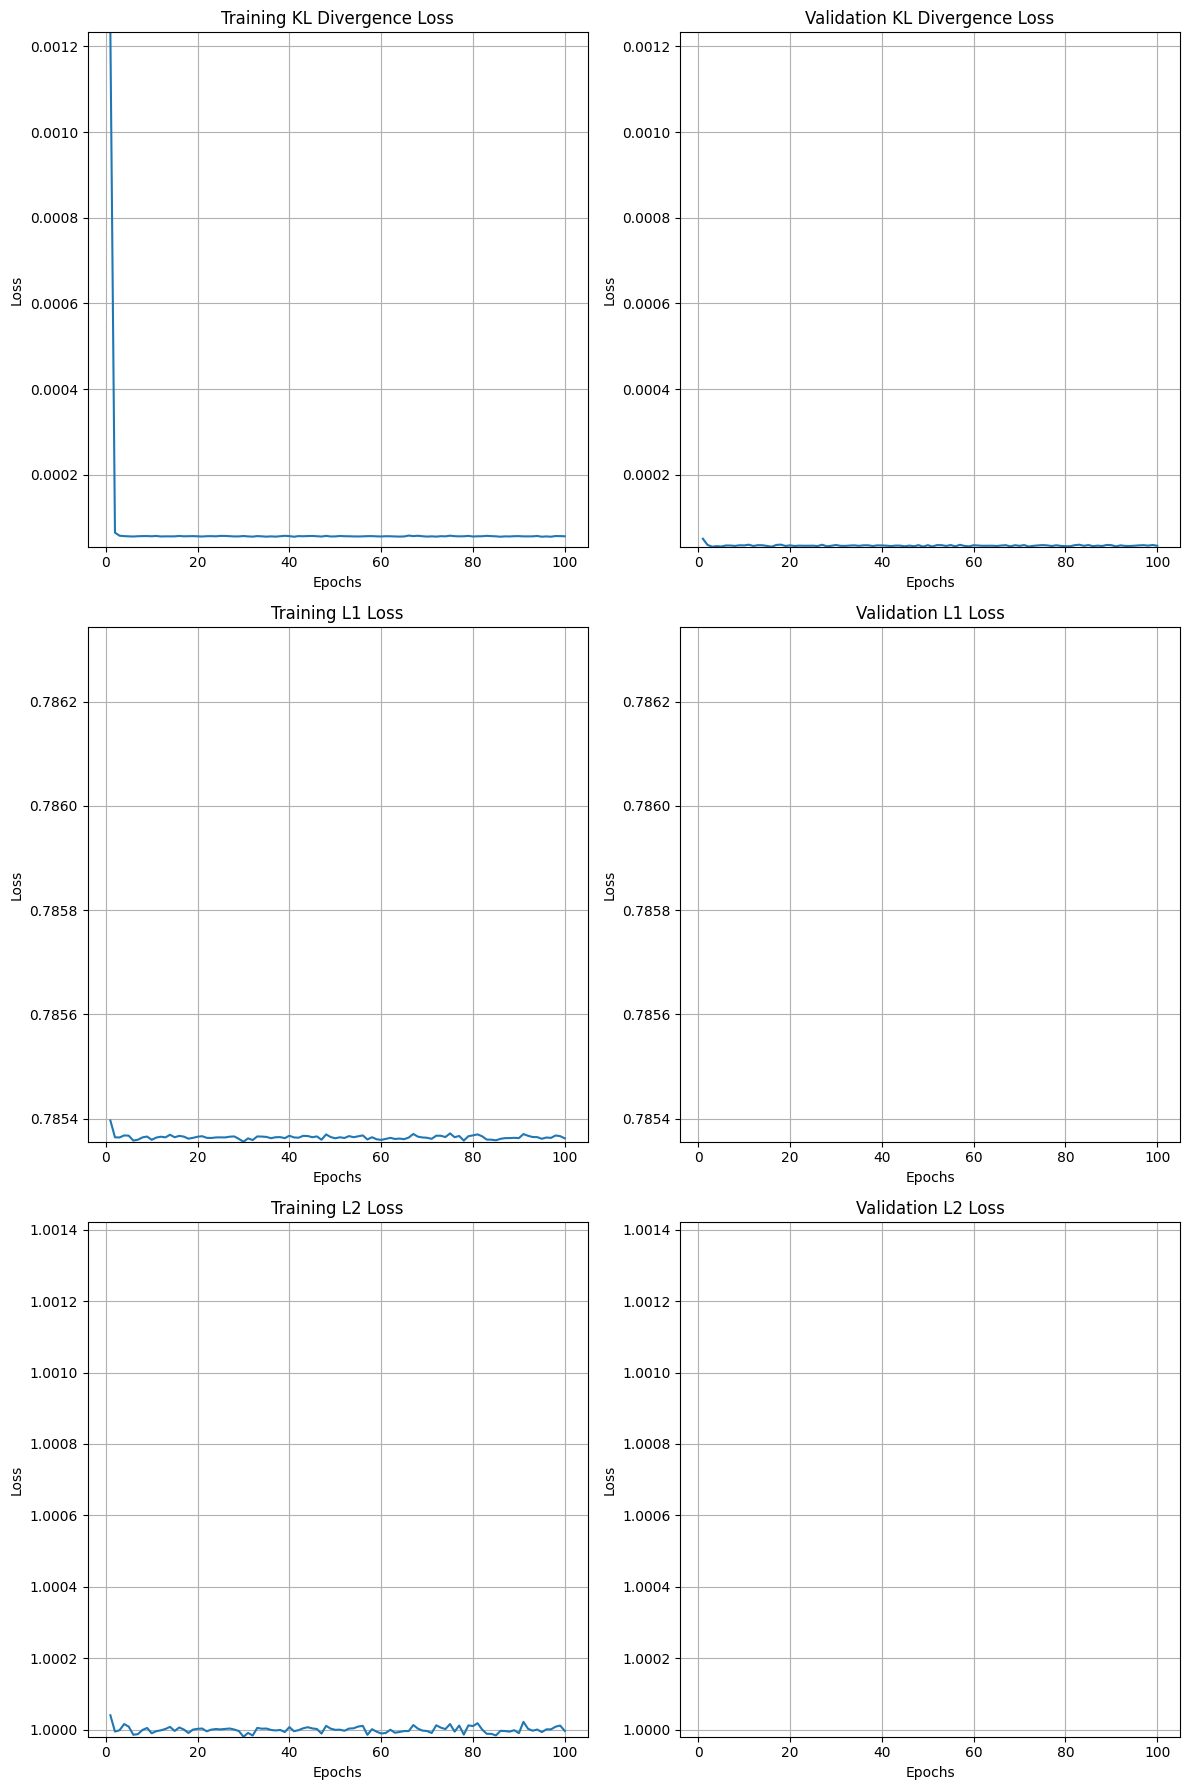

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
79.5465 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 14/14 [00:12<00:00,  1.09it/s]


z0: 0.0004
z1: 0.0002
z2: -0.0002
z3: -0.0004


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 766.08it/s]


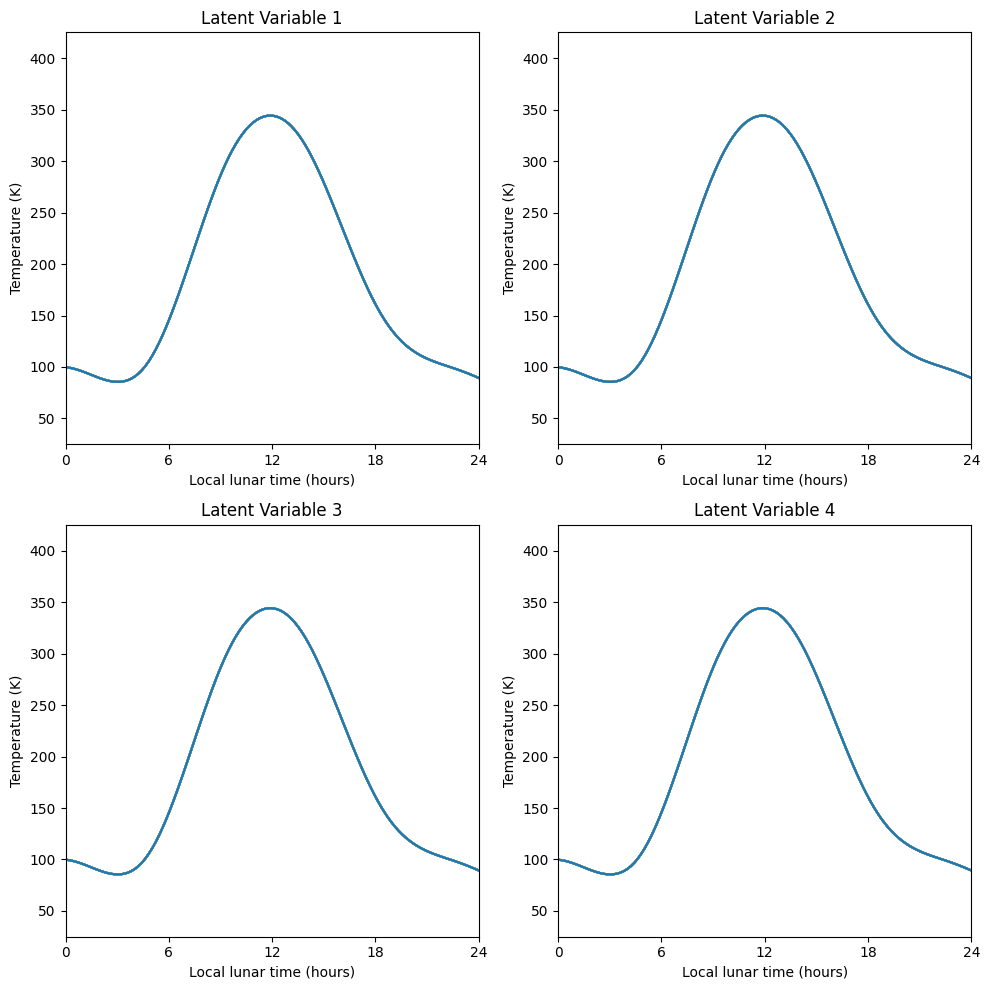

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)